# <u>Walmart Product Review Analysis <u/>

### Goal
This analysis will look at Walmart clothing reviews to find key features that predict whether a customer will recommend an item or not. This investigation will be conducted using [Natural Language Processing](https://en.wikipedia.org/wiki/Natural_language_processing) packages and libraries. The features that guide the predictions can then used to guide Walmart's online and/or in-store marketing/product campaigns. 
### Notebook
Notebook ```2_walmart_product_review_nlp``` has cleaned the text and generated additional features. This notebook is for modeling determine the validity of the dataset and potentially extract features to explain why items are recommended or not recommended. 

In [1]:
# Data Cleaning and analysis packages
import pandas as pd
import numpy as np


# NLP packages
import gensim
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer

# Sats and Modeling packages
from sklearn import metrics
from scipy import stats
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

# Visualization packages
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import pickle
import warnings
warnings.filterwarnings("ignore") 


pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 200)

In [2]:
filename = "data/modeling_df.pkl"

In [3]:
infile = open(filename,"rb")
df = pickle.load(infile)
infile.close()

In [4]:
# confirming dataframe is not corrupted
df.head(2)

,item_name,price,overall_rating,num_rating,recommend,review_text,section,target,rating_bin,clean_review_text,tokenized,rem_stop,lemma_words,delisted,girls',men's,women's,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,Wrangler Men's Unlined Shirt Jacket,12.0,4.0,7.0,80.0,['I bought this last year and am going to buy ...,men's clothing,0,1,i bought this last year and am going to buy an...,"[i, bought, this, last, year, and, am, going, ...","[bought, last, year, going, buy, another, frid...","[bought, last, year, going, buy, another, frid...","bought, last, year, going, buy, another, frida...",0.0,1.0,0.0,0.011115,0.011115,0.011115,0.122070,0.011115,0.011115,0.789009,0.011115,0.011115,0.011115,0.011115,0.011115,0.011115,0.122070,0.011115,0.011115,0.789009,0.011115,0.011115,0.011115,0.011115,0.011115,0.011115,0.122070,0.011115,0.011115,0.789009,0.011115,0.011115,0.011115
1,Wrangler Men's Relaxed Fit Jeans,12.0,4.5,5840.0,90.0,"['I like wrangler, the pants is exactly for my...",men's clothing,1,1,i like wrangler the pants is exactly for my bo...,"[i, like, wrangler, the, pants, is, exactly, f...","[like, wrangler, pants, exactly, body, also, g...","[like, wrangler, pant, exactly, body, also, go...","like, wrangler, pant, exactly, body, also, goo...",0.0,1.0,0.0,0.000000,0.000000,0.000000,0.010731,0.000000,0.000000,0.987497,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010731,0.000000,0.000000,0.987497,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010731,0.000000,0.000000,0.987497,0.000000,0.000000,0.000000


In [5]:
# confirming dataframe has no new null values. 
df.isna().sum()

item_name            0
price                0
overall_rating       0
num_rating           0
recommend            0
review_text          0
section              0
target               0
rating_bin           0
clean_review_text    0
tokenized            0
rem_stop             0
lemma_words          0
delisted             0
girls'               0
men's                0
women's              0
topic0               0
topic1               0
topic2               0
topic3               0
topic4               0
topic5               0
topic6               0
topic7               0
topic8               0
topic9               0
topic0               0
topic1               0
topic2               0
topic3               0
topic4               0
topic5               0
topic6               0
topic7               0
topic8               0
topic9               0
topic0               0
topic1               0
topic2               0
topic3               0
topic4               0
topic5               0
topic6     

Now that we have cleaned the continuous variables, tokenized the raw text, removed stopwords, lemmatized words to their roots and generated LDA Topic scores, we can dive into modeling.

# Train Test Split

Item name, review text, clean review text,  features will be dropped because we cannot run strings in the model. 
They were generated simply for keeping track of feature engineering.  

In [6]:
drop_features = ["item_name", "overall_rating", "rating_bin", "recommend",
                 "clean_review_text", "review_text", "section", "tokenized", 
                 "rem_stop", "lemma_words", "target"]

In [7]:
X = df.drop(columns = drop_features)
y = df["target"].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [9]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(919, 36) (919,) (230, 36) (230,)


# Stopwords

In [10]:
# Extracted the stopwords from my preprocessing notebook to be used for the TfidfVectorizer
eda_stopwords = ["nd", "de", "u", "la", "tbw", "c", "v", "great", "n", "wal", "wow","hi", "hello", "nmbc", "youll", "must", "said", "either", "lol", 'ill', "six", "goat", "thou", "un", "lb", "pair", "right", "x", "xl", "one", "way", "definitely", "shirt", "jacket", "daughter", "son" ]

stop_words=list(set(stopwords.words("english")))

stop_words.extend(eda_stopwords)

# CountVectorizer

I ran a CountVectorizer to experiment and TFIDF performed better. However, if you would like to try, you can uncomment the cell below and run it. But please comment out the TfidfVectorizer cell. 

In [11]:
# # CountVec
# countvec = CountVectorizer(stop_words = stop_words, analyzer="word", ngram_range=(1,2), max_features=5000)
# train_vec = countvec.fit_transform(X_train.delisted.values).toarray()
# test_vec = countvec.fit_transform(X_test.delisted.values).toarray()


# count_train = pd.DataFrame(train_vec, columns = countvec.get_feature_names())
# count_test = pd.DataFrame(test_vec, columns = countvec.get_feature_names())

# print(f"X train shape: {X_train.shape}, Count train shape: {count_train.shape}") 
# print("-"*20)
# print(f"X test shape: {X_test.shape}, Count test shape: {count_test.shape}")

# # resetting index to concatenate with tfidf. Resetting index will not affect the dataset. 
# X_train.reset_index(drop=True, inplace=True)
# X_test.reset_index(drop=True, inplace=True)

# frame1 = [X_train, count_train]
# frame2 = [X_test, count_test]

# X_train = pd.concat(frame1, axis=1)
# X_test = pd.concat(frame2, axis=1)

# TfidfVectorizer

The reason for doing TfidfVectorizer after Train-Test Split is to prevent data leakage. 

In [12]:
tfidfvec = TfidfVectorizer(stop_words = stop_words, ngram_range = (1,2), max_features=2000, use_idf=True)  

train_vec = tfidfvec.fit_transform(X_train.delisted.values).toarray()
test_vec = tfidfvec.fit_transform(X_test.delisted.values).toarray()

tfidf_train = pd.DataFrame(train_vec, columns = tfidfvec.get_feature_names())
tfidf_test = pd.DataFrame(test_vec, columns = tfidfvec.get_feature_names())

print(f"X train shape: {X_train.shape}, Tfidf train shape: {tfidf_train.shape}") 
print("-"*20)
print(f"X test shape: {X_test.shape}, Tfidf test shape: {tfidf_test.shape}")

# resetting index to concatenate with tfidf. Resetting index will not affect the dataset. 
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

frame1 = [X_train, tfidf_train]
frame2 = [X_test, tfidf_test]

X_train = pd.concat(frame1, axis=1)
X_test = pd.concat(frame2, axis=1)

X_train.head(2)

X train shape: (919, 36), Tfidf train shape: (919, 2000)
--------------------
X test shape: (230, 36), Tfidf test shape: (230, 2000)


,price,num_rating,delisted,girls',men's,women's,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,able,able wear,absolutely,absolutely adorable,absolutely love,absolutely loved,acceptable,accessory,according,accurate,across,active,activity,actual,actually,actually fit,add,added,addition,adjust,adjustable,adjustable waist,adorable,adult,advertised,affordable,age,ago,air,air dry,allow,almost,almost like,alone,along,already,also,also comfortable,also like,also love,although,always,always fit,amazing,amount,ankle,annoying,another,anymore,anyone,anything,anyway,anywhere,apart,appearance,appears,appreciate,appropriate,area,arm,armpit,around,around ankle,around house,arrived,arrived quickly,athletic,athletic workout,attractive,available,average,away,awesome,awful,awkward,baby,back,back pocket,back school,bad,bag,baggy,ball,band,band size,bar,barely,bargain,based,baselayer,baselayer cool,basic,basically,batch,bathrobe,battery,bc,beat,beat price,beautiful,beautiful color,beautiful dress,beautifully,become,bed,behind,believe,belly,belt,bend,bending,best,best fitting,best part,...,washed well,washed yet,washer,washing,washing machine,waste,waste money,watch,water,water resistant,wear,wear also,wear anything,wear around,wear bra,wear day,wear dress,wear fit,wear get,wear large,wear love,wear medium,wear ordered,wear pant,wear school,wear size,wear skirt,wear wear,wear well,wear work,wear would,wearable,wearing,wearing bra,weather,website,week,weekend,weigh,weight,weight fabric,weird,well,well comfortable,well constructed,well done,well fit,well good,well like,well look,well love,well made,well nice,well worth,went,went back,went size,wet,whatever,white,whole,wide,wider,width,win,wind,winter,winter coat,winter month,wire,wish,wish color,wish could,wish would,within,without,woman,wonder,wonder long,wonder nation,wonderful,wonderfully,wont,word,wore,work,work well,worked,working,workout,workout running,worn,worried,worst,worth,worth money,worth price,would,would buy,would fit,would get,would go,would like,would look,would love,would make,would never,would nice,would order,would probably,would purchase,would recommend,would say,would suggest,would tight,would wear,wouldnt,wrangler,wrangler jean,wrap,wrap around,wrap dress,wrinkle,wrinkled,wrist,write,writing,wrong,wrong size,wrote,xa,xxl,yard,yeah,year,year ago,year always,year love,year old,yellow,yes,yesterday,yet,yo,younger,yr,yr old,zero,zip,zipper
0,11.94,13.0,"thick, material, quality, product, great, pric...",1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.976310,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.976310,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.976310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157222,0.0,0.0,0.0,0.0,0.090021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.062148,0.144774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.00,3.0,"hoodie, little, thinner, side, daughter, love,...",1.0,0.0,0.0,0.0,0.0,

In [13]:
# Dropping "delisted" from both Train and Test because these have already been Vectorized. 
X_train.drop(columns = ["delisted"], inplace = True)
X_test.drop(columns = "delisted", inplace=True)
X.drop(columns = ["delisted"], inplace = True)

In [88]:
def model_metrics(y_test, y_pred):

    '''Shows Accuracy, Precision, Recall, and F1-Score evaluation metrics'''

    print('Evaluation Metrics:')
    print('Accuracy: ' + str(metrics.accuracy_score(y_test, y_pred)))
    print('Precision: ' + str(metrics.precision_score(y_test, y_pred)))
    print('Recall: ' + str(metrics.recall_score(y_test, y_pred)));

In [82]:
def cross_validation(model, X_train, y_train, cv=5, n_jobs=-1):
    '''Prints cross-validation metrics for evaluation'''

    score = cross_val_score(model, X_train, y_train, cv=cv, scoring = "f1", n_jobs=n_jobs)
    print('Cross-Validation F1 Scores:', score)
    print('Mean F1 Scores: ', round(score.mean(), 5));

In [76]:
def con_mat(X, y, title=None):
    cm = confusion_matrix(X, y)
    fig, ax = plt.subplots(figsize = (14,6))
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')
    ax.set_xticklabels(['Not Recommended', 'Recommended'])
    ax.set_yticklabels(['Not Recommended', 'Recommended'])
    ax.set_ylabel('Actual', size=15)
    ax.set_xlabel('Predicted', size=15)
    return plt.show();

# Dummy Classifier

In [77]:
dummy_clf = DummyClassifier(strategy="stratified")

In [78]:
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='stratified')

Evaluation Metrics:
Accuracy: 0.6434782608695652
Precision: 0.7674418604651163
Recall: 0.7586206896551724
None
------------------------------------------------------------
Cross-Validation F1 Scores: [0.73529412 0.6969697  0.74285714 0.75757576 0.81081081]
Mean F1 Scores:  0.7487
------------------------------------------------------------


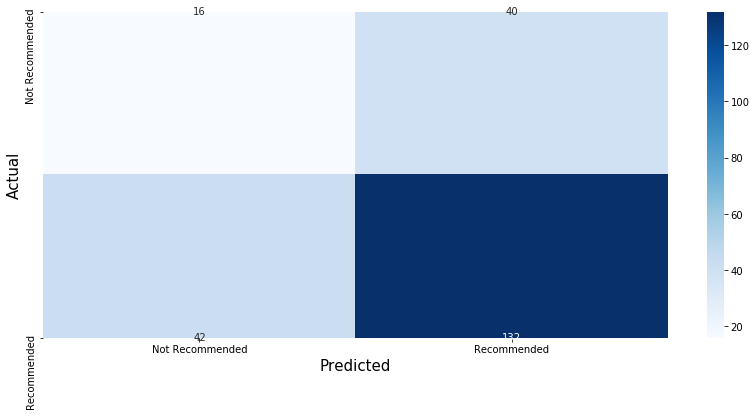

In [91]:
y_preds_dum = dummy_clf.predict(X_test)
print(model_metrics(y_test, y_preds_dum));                 
print("-"*60)
cross_validation(dummy_clf, y_test, y_preds_dum)
print("-"*60)
con_mat(y_test, y_preds_dum, title="Dummy Classifier")

Accuracy for dummy is a bit higher than expected. Additionally, there is a good amount of False Negative and False positive in the confusion matrix. This might be due to the class imbalance. F1 score of 0.75 can also be explained due to the class imbalance.

I will use class_weight="balanced" to combat this. 

# Logistic Regression Baseline

In [92]:
logreg_clf = LogisticRegression(random_state = 0,n_jobs=-1)
logreg_clf.fit(X_train, y_train)

LogisticRegression(n_jobs=-1, random_state=0)

Evaluation Metrics:
Accuracy: 0.7652173913043478
Precision: 0.7702702702702703
Recall: 0.9827586206896551
None
------------------------------------------------------------
Cross-Validation F1 Scores: [0.85618729 0.85714286 0.84949833 0.85714286 0.85148515]
Mean F1 Scores:  0.85429
------------------------------------------------------------


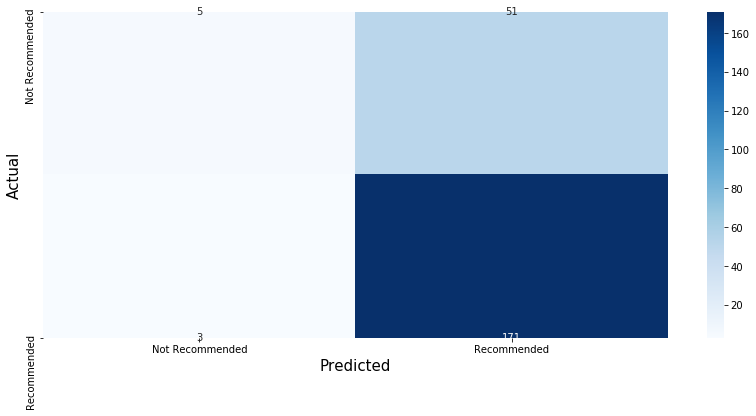

In [93]:
y_pred_lr = logreg_clf.predict(X_test)
print(model_metrics(y_test, y_pred_lr))
print("-"*60)
cross_validation(logreg_clf, X_train, y_train)
print("-"*60)
con_mat(y_test, y_pred_lr, title="Logistic Regression")

Although we acheive a decent F1 score of 0.85, the class imabalnce is causing the model to lean in favor of the dominant class. The recall score is at 0.98, which means that when it's actually "recommended", our model predict correctly 98 percent of the time. This is pretty good. However, the True negative rate is really low. There are 56 cctual Non Recommended items but only 8 were predicted and of those 8, only 5 were correct. 

# Logistic Regression with Class weight as Balanced

In [84]:
logreg_clf2 = LogisticRegression(random_state = 0,n_jobs=-1, class_weight="balanced")
logreg_clf2.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=0)

Evaluation Metrics:
Accuracy: 0.5956521739130435
Precision: 0.824
Recall: 0.5919540229885057
None
------------------------------------------------------------
Cross-Validation F1 Scores: [0.768      0.80916031 0.81300813 0.72881356 0.78787879 0.86363636
 0.80952381 0.828125   0.88888889 0.75409836]
Mean F1 Scores:  0.80511
------------------------------------------------------------


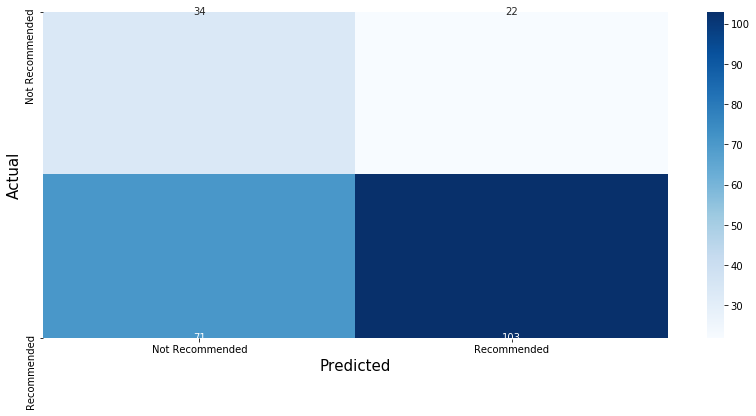

[[ 34  22]
 [ 71 103]]


In [95]:
y_pred_lr2 = logreg_clf2.predict(X_test)
print(model_metrics(y_test, y_pred_lr2))
print("-"*60)
cross_validation(logreg_clf2, X_train, y_train, cv=10)
print("-"*60)
con_mat(y_test, y_pred_lr2, title="Logistic Regression")
print(confusion_matrix(y_test, y_pred_lr2))

Although F1 score is still faily high at 0.805 after balancing the class weight, the recall dropped to 0.59 and False Negative also increased dramatically. Nonetheless, actual Non Recommended items were predicted correctly at a higher rate. Since, Walmart has a ton of items, falsly predicting some recommended items as not recommended does not hurt drastically. We still have a decent precision rate at 0.824. Precision rate is calucated by answering, When model predicted Recommended, how often is it correct? So, predicting corretly at 82.4% is still a win.  

# Bernoulli Naive Bayes Baseline

In [56]:
B_nb = BernoulliNB()
B_nb.fit(X_train, y_train)

BernoulliNB()

In [57]:
y_pred_Bnb = B_nb.predict(X_test)
print(model_metrics(y_test, y_pred_Bnb))

Evaluation Metrics:
Accuracy: 0.7043478260869566
Precision: 0.7819148936170213
Recall: 0.8448275862068966
F1 Score: 0.8121546961325967
None


In [59]:
cross_validation(B_nb, X_train, y_train, cv=10)


Cross-Validation F1 Scores: [0.81751825 0.78461538 0.83211679 0.81538462 0.8137931  0.85496183
 0.84210526 0.8        0.78195489 0.71212121]
Mean F1 Scores:  0.80546


In [20]:
x = (cross_val_score(B_nb, X_test, y_test, scoring="f1", cv=10))
print(x)
print(f"Mean is {np.mean(x)}")

[0.89473684 0.87804878 0.92307692 0.87179487 0.86486486 0.91428571
 0.75       0.89473684 0.88888889 0.76470588]
Mean is 0.8645139609962535


# SVC Radial Basis Function Test

In [21]:
from sklearn.svm import SVC

In [22]:
clf_rbf = SVC(kernel='rbf', class_weight="balanced", probability=True)
clf_rbf.fit(X_train, y_train)

SVC(class_weight='balanced', probability=True)

In [23]:
y_pred_rbf = clf_rbf.predict(X_test)
print("F1 score is:", metrics.f1_score(y_test, y_pred_rbf))

F1 score is: 0.8373333333333333


In [24]:
x = (cross_val_score(clf_rbf, X_train, y_train, scoring="f1", cv=10))
print(x)
print(np.mean(x))

[0.85714286 0.85714286 0.84768212 0.80821918 0.79432624 0.83116883
 0.80263158 0.78378378 0.80536913 0.78911565]
0.8176582220383221


# Random Forest Classifier

In [25]:
rfc_classifier = RandomForestClassifier(n_estimators = 300, criterion = "entropy", random_state = 0, class_weight="balanced")

In [26]:
rfc_classifier.fit(X_train, y_train)
y_pred_RF = rfc_classifier.predict(X_test)
print("F1 score is:", metrics.f1_score(y_test, y_pred_RF))
print()

F1 score is: 0.8492462311557789



In [27]:
%time
x = (cross_val_score(rfc_classifier, X_train, y_train, scoring="f1", cv=10))
print(x)
print(f"Mean is {np.mean(x)}")

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 5.01 µs
[0.85333333 0.82432432 0.8516129  0.85333333 0.84415584 0.85714286
 0.86092715 0.85714286 0.87417219 0.87248322]
Mean is 0.8548628011883211


In [28]:
# Logistic Regression:
print("Logistic Regression F1 score is:", metrics.f1_score(y_test, y_pred_lr))
# Bernoulli NB
print("Bernoulli F1 score is:", metrics.f1_score(y_test, y_pred_Bnb))
# SVC- Radial Basis Funciton
print("SVC RBF F1 score is:", metrics.f1_score(y_test, y_pred_rbf))
# Random Forest
print("Random Forest F1 score is:", metrics.f1_score(y_test, y_pred_RF))

Logistic Regression F1 score is: 0.8636363636363636
Bernoulli F1 score is: 0.8396946564885496
SVC RBF F1 score is: 0.8373333333333333
Random Forest F1 score is: 0.8492462311557789


The top three models that performed the best are RandomForest, Bernoulli Naive Bayes and Logistic Regression. I will use the GridSearch with Logistic Regression and RandomForest to see what the best parameters are and how the score changes. 

# GridSearchCV with Random Forest Classifier

In [29]:
rfc = RandomForestClassifier(n_estimators = 300, criterion = "entropy",
                             random_state = 0, verbose=1, n_jobs=-1, class_weight="balanced")

param_dict={'min_samples_leaf':range(1,10,1), 'max_depth': range(1,10,1), "max_leaf_nodes":range(5,11,1)}

grid_tree = GridSearchCV(rfc, param_dict, cv=5, scoring="f1", verbose=2, n_jobs=-1)
grid_tree.fit(X_train, y_train)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  8.6min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.4s finished


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              criterion='entropy',
                                              n_estimators=300, n_jobs=-1,
                                              random_state=0, verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 10),
                         'max_leaf_nodes': range(5, 11),
                         'min_samples_leaf': range(1, 10)},
             scoring='f1', verbose=2)

In [30]:
grid_tree_pred = grid_tree.predict(X_test)
print("F1 score is:", metrics.f1_score(y_test, grid_tree_pred))
print("-"*60)
print(grid_tree.best_params_)
print("-"*60)
print(grid_tree.best_estimator_)
print("-"*60)
print(grid_tree.best_estimator_.feature_importances_)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.1s finished


F1 score is: 0.8385416666666667
------------------------------------------------------------
{'max_depth': 2, 'max_leaf_nodes': 5, 'min_samples_leaf': 4}
------------------------------------------------------------
RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=2, max_leaf_nodes=5, min_samples_leaf=4,
                       n_estimators=300, n_jobs=-1, random_state=0, verbose=1)
------------------------------------------------------------
[0.01092932 0.00115715 0.         ... 0.00129997 0.         0.        ]


Interesting! RandomForest performed better than GridSearchCV with RandomForest. I will extract the feature importance from this to see how it comapres with Logistic Regression coefficients. 

# GridSearchCV with Logistic Regression

In [31]:
logreg = LogisticRegression(random_state = 0, n_jobs=-1, verbose=2)
log_dict = {'tol': [8,9,10,11,12], 'C': [1,5], 'penalty': ["l1", "l2"]}

In [32]:
grid_log = GridSearchCV(logreg, log_dict, cv=5, scoring="f1", verbose=2, n_jobs=-1)
grid_log.fit(X_train, y_train)
#rfc.fit(X_train_tfidf, y_train_tfidf)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    6.2s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


GridSearchCV(cv=5,
             estimator=LogisticRegression(n_jobs=-1, random_state=0, verbose=2),
             n_jobs=-1,
             param_grid={'C': [1, 5], 'penalty': ['l1', 'l2'],
                         'tol': [8, 9, 10, 11, 12]},
             scoring='f1', verbose=2)

In [33]:
grid_log_pred = grid_log.predict(X_test)
print("F1 score is:", metrics.f1_score(y_test, grid_log_pred))

F1 score is: 0.8475452196382429


In [34]:
print(grid_log.best_params_)
print("-"*60)
print(grid_log.best_estimator_)
print("-"*60)

{'C': 5, 'penalty': 'l2', 'tol': 8}
------------------------------------------------------------
LogisticRegression(C=5, n_jobs=-1, random_state=0, tol=8, verbose=2)
------------------------------------------------------------


In [35]:
# Grid Search - Random Forest
print("GridSearchCV w/ Random Forest F1 score is:", metrics.f1_score(y_test, grid_tree_pred))
# Grid Search - Logistic Regression
print("GridSearchCV w/ Logistic Regression F1 score is:", metrics.f1_score(y_test, grid_log_pred))

GridSearchCV w/ Random Forest F1 score is: 0.8385416666666667
GridSearchCV w/ Logistic Regression F1 score is: 0.8475452196382429


# Overall Scores using TFIDF

In [96]:
# from matplotlib.ticker import FormatStrFormatter
# fig, ax = plt.subplots(figsize=(12,8))
# x = ["Logistic", "Bernoulli", "SVC RBF", "RandomForest", "GSRF", "GSLR"]
# y = [metrics.f1_score(y_test, y_pred_lr), metrics.f1_score(y_test, y_pred_Bnb), 
#      metrics.f1_score(y_test, y_pred_rbf),
#      metrics.f1_score(y_test, y_pred_RF), metrics.f1_score(y_test, grid_tree_pred),
#      metrics.f1_score(y_test, grid_log_pred)]
# sns.barplot(x=x, y=y)
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# plt.ylabel("F1 Score", fontsize=15)
# plt.xlabel("Classifier", fontsize=15)
# plt.title("F1 Score per Classifier", fontsize=25)
#plt.savefig("images/f1score");

The Logistic Regression and GridSearch with Logistic Regression provides the same score. 
Second place with a very thin difference is Random Forest. Surprisingly, the GridSearch with Random Forest resulted in a worse score than a regualr Random Forest. 

# Feature Importances

### Feature Importance from Logistic Regression

In [37]:
def get_coef_name(fit_model, df):
    temp = (list(zip(fit_model.coef_[0], df.columns)))
    return sorted(temp,key = lambda x: x[0], reverse=True)

In [38]:
log_reg_coef=pd.DataFrame(get_coef_name(logreg_clf, X_train), columns = ["coefficient", "feature"])

In [39]:
# top 5 (positive) and Bottom 5 (negative) gives you the 5 most positve and 5 most negative values. 
top5_coef = pd.concat([log_reg_coef.head(8),log_reg_coef.tail(8)])

Text(0, 0.5, 'Log(odds)')

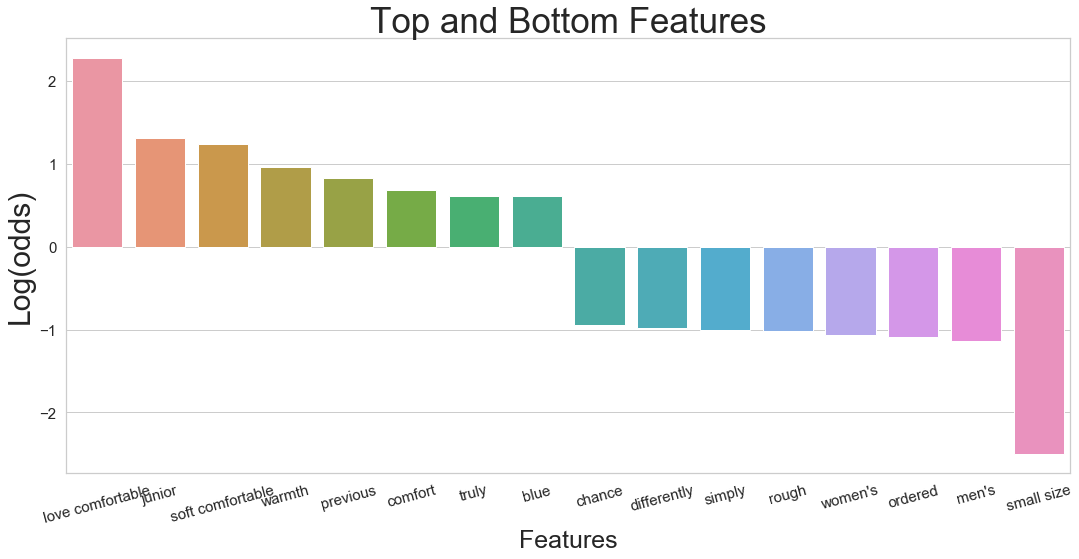

In [40]:
fig, ax = plt.subplots(figsize = (18,8))
sns.barplot(x = top5_coef.feature, y=top5_coef.coefficient)
plt.title("Top and Bottom Features", fontsize=35)
plt.xlabel("Features", fontsize=25)
plt.xticks(rotation=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("Log(odds)", fontsize=30)
#plt.savefig("images/log_coef_feats");

### Feature Importance from Random Forest

In [41]:
def get_feats_name(fit_model, df):
    temp = (list(zip(fit_model.best_estimator_.feature_importances_, df.columns)))
    return sorted(temp,key = lambda x: x[0], reverse=True)

In [42]:
grid_tree_feats=pd.DataFrame(get_feats_name(grid_tree, X_train), columns = ["importance", "feature"])

In [43]:
top_grid_feats =grid_tree_feats.head(12)

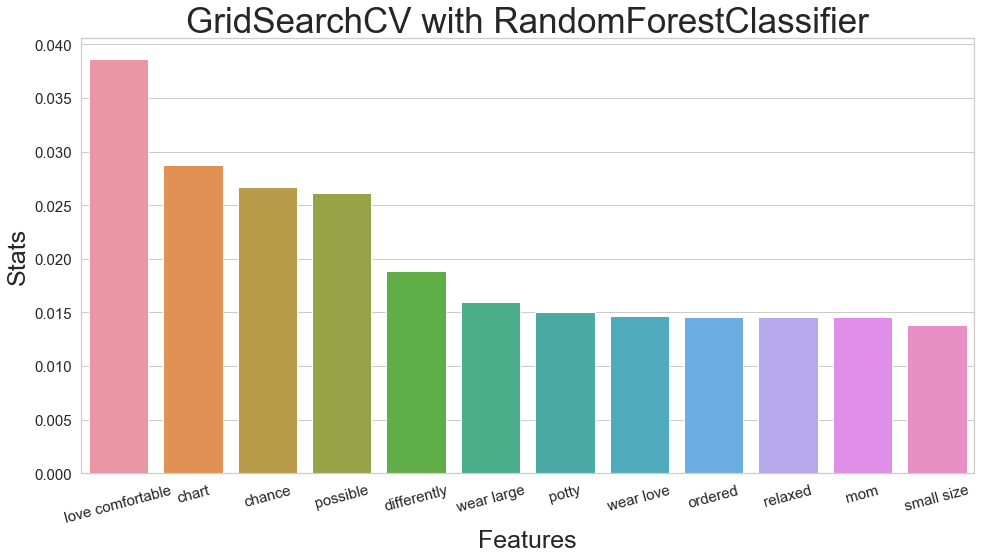

In [44]:
fig, ax = plt.subplots(figsize = (16,8))
sns.barplot(x = top_grid_feats.feature, y=top_grid_feats.importance)
plt.title("GridSearchCV with RandomForestClassifier", fontsize=35)
plt.xlabel("Features", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("Stats", fontsize=25)
plt.xticks(rotation=15)
plt.savefig('images/grid_tree.png');

# Post Modeling Study for Feature Importances

The Modeling study will consist of checking how these features found by Logistic Regression and GridSearchCV with RandomForest are use in the actual raw review.

As part of the MVP Project, this will be the scope of this study for Feature importances. As for the Stretch goal, I would like to dig in deeper and see if these features really do drive recommendation is postive and negative ways. 

In [45]:
#df[df["delisted"].str.contains("fit")]

In [46]:
#df.iloc[1124].review_text

# Conclusion

My models produced a decent F1 score and the features extracted from the Logistic Regression and GridSearchCV with RandomForest Classifier support each other. 

Therefore, my recommendation to Walmart marketing team would be to promote items that are true to size. If items fit well, then it is often recommended. Additionally, a proper fit is also "comfortable" and my analysis found that "comfort" drives recommendation.  Whereas, Customer's having to return products due to sizing issues seem to push items to being non-recommended. 

One way to tackle this would to be do additional research and tests on the partner brands to see how ture to size their products are. 

Additionally, it seems like quality control needs to be addressed. 

* "When we opened the vacuum sealed packaging that this Mario suit came in, we were completely overwhelmed by a smell of mold and mildew."
* "First, the sweater came smelling really bad like vinegar. Worst of all, the design came off after just one wash!"

Walmart partners with brands, large and small, and sells their items online. However, when items are received by the customers in bad condition, Walmart receives the blame causing their public image to be degraded. 


## Next Steps


During this analysis, I discovered that Brand's would get compared to each other in the reviews. I found multiple instances wherer this occurs but I could only find one again to demostrate as example: An inner wear item, Disney Junior Toddler Girls Sofia the First, was compared to Fruit of The Loom.


* "Seams are starting to unravel after first use. Spend the extra money on Hanes brand or Fruit of a Loom..so disappointed..."

Another place I would like to spend more time is exploring whether lemmatize or stemming should even be considered. For instance, "Slip" was lemmatized from Slippers, slippery, slips, slipping. Slip was being refered correctly at itmes, where customers were talking about how the elastic does not perform well and causes the pants to slip and the item was not recommended. And other times, it was lemmatized from slippers


* "Hubby also claims they slip down easily if not tied tightly."

* "I sadly had to return my ballet slipper because I ordered the wrong size."

# For further clarification or inquiries:
For further clarificaiton or inquiries you can email: ```dorjeys3@gmail.com``` with your questions.
You can also find me [here](https://www.linkedin.com/in/dorjey-sherpa-45501814a/) on LinkedIn